In [1]:
import matplotlib.pyplot as plt
from scipy.stats import describe
import numpy as np
import pandas as pd
import operator
from astropy.table import QTable, Table, Column
from astropy import units as u

                                                      PROBLEMA DE RUINA


$$X_{t}= x_0 +ct - \sum_{i=1} ^ {N_t} Zi$$
             
Donde $Z_i$ se distribuye exponencial.

Probar la condicion de ganancia neta $$c>\frac{(\mu_{1_H} \rho + a \delta)}{(\delta-\mu_{1G})}\mu_{1_Z}$$
donde $x_0$ es constante y $c$ es constante

Se realizará la simulación propuesta por Dassios y Zhao para calcular los tiempos de saltos del modelo.

In [2]:
def simulation2(a,rho,delta,alpha,beta,lambda0,T):
    T0=0
    Nt=[]
    Nt.append(0)
    E=(-1/rho)*(np.log(np.random.uniform(0,1)))
    d1=1+((delta*np.log(np.random.uniform(0,1)))/lambda0-a)
    lambdat=[]
    Ti=[]
    size=[]
    if d1>0:
        S1=(-np.log(d1))/delta
        S2=(-np.log(np.random.uniform(0,1)))/a
        S= min(S1,S2)
    else:
        S2=(-np.log(np.random.uniform(0,1)))/a
        S=S2
    Ti.append(T0+min(S,E))
    lambdamenos=a+(lambda0-a)*np.exp(-delta*(Ti[0]-T0))
    if S<E:
        SJ=np.random.exponential(scale=1/beta)
        lambdat.append(lambdamenos+SJ)
        size.append(SJ)
        N=1
    else:
        EJ=np.random.exponential(scale=1/alpha)
        lambdat.append(lambdamenos+EJ)
        size.append(EJ)
        N=0
    Nt[0]=N
    i=1
    Tx=Ti[-1]
    while Tx<T:
        E=(-1/rho)*(np.log(np.random.uniform(0,1)))
        d1=1+((delta*np.log(np.random.uniform(0,1)))/lambdat[i-1]-a)
        if d1>0:
            S1=(-np.log(d1))/delta
            S2=(-np.log(np.random.uniform(0,1)))/a
            S= min(S1,S2)
        else:
            S2=(-np.log(np.random.uniform(0,1)))/a
            S=S2
        Tx=Ti[i-1]+min(S,E)
        if Tx>T:
            break
        Ti.append(Tx)
        lambdamenos=a+(lambdat[i-1]-a)*np.exp(-delta*(Ti[i]-Ti[i-1]))
        if S<E:
            SJ=np.random.exponential(scale=1/beta)
            lambdat.append(lambdamenos+SJ)
            size.append(SJ)
            N=1+N
        else:
            EJ=np.random.exponential(scale=1/alpha)
            lambdat.append(lambdamenos+EJ)
            size.append(EJ)
            N=0+N
        Nt.append(N)
        i=i+1
        if i==1000000:
            break
    return Ti,Nt,N,lambdat,size

$\quad$

Los parámetros a utilizar durante la primera simulación serán:
$$(a,\rho,\delta,\alpha,\beta,\gamma,\lambda_0,T,c,x_0)=(0.7,0.5,2.0,2.0,1.5,1.0,0.7,50,1.5,10) $$

$\quad$

In [40]:
a=0.7;rho=0.5;delta=2.0;alpha=2.0;beta=1.5;gamma=1.0;lambda0=0.7;T=50;c=1.5;x_0=10

In [48]:
Ti,Nt,N,lambdat,size=simulation2(a,rho,delta,alpha,beta,lambda0,T)
max(Nt)

33

In [5]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        intr=Nt[0]
        
    else:
        intr=Nt[i]-Nt[i-1]
    Nt_final.append(intr)    
    i=i+1
    if i ==10000000:
        break

In [6]:
#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

                                                     GRÁFICAS

La gráfica del proceso puntual respecto a el tiempo nos permitirá conocer los tiempos en los cuales ocurrren saltos internos y en cuales se mantiene constante teniendo saltos externos en algún instante $T_i$

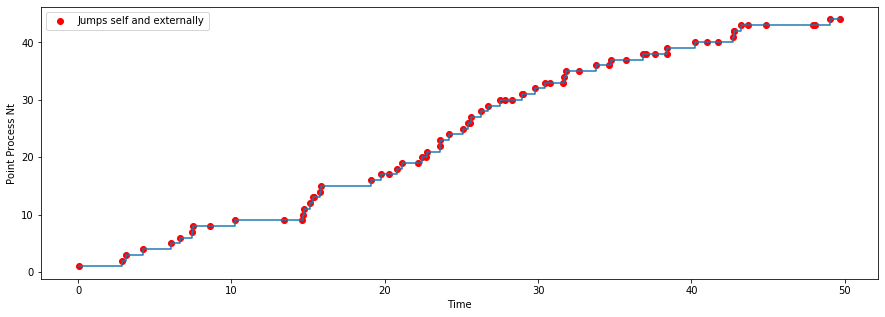

In [7]:
plt.figure(figsize=(15,5))
plt.scatter(Ti,Nt,label='Jumps self and externally',color='red')
plt.step(Ti,Nt,where='post')
#plt.title('Ti vs Nt')
plt.xlabel('Time')
plt.ylabel('Point Process Nt')
plt.legend()
#plt.savefig("Proceso_Conteo.jpg", bbox_inches='tight')

Siguiendo la simulación para el proceso de intensidad $\lambda_t$ podemos obtener los tiempos en los cuales ocurren saltos junto con su respectiva intesidad para ese instante de tiempo  

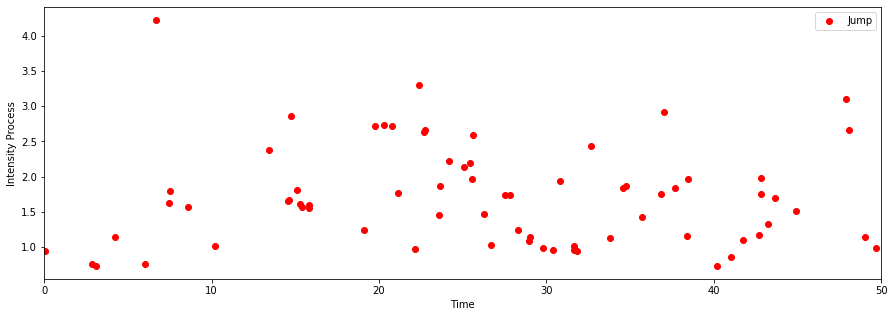

In [8]:
plt.figure(figsize=(15,5))
plt.xlim(0,T)
plt.scatter(Ti,lambdat,label='Jump',color='red')
plt.xlabel('Time')
plt.ylabel('Intensity Process')
plt.legend()
#plt.savefig("Proceso_Intensidad.jpg", bbox_inches='tight')

Se realizará una modificación al algoritmo de simulación de tal manera que se puedan conocer la diferencia entre la ocurrencia de un salto interno y uno externo. Esto nos servirá para calcular la media de cada uno de ellos y poder realizar el cálculo de la condición de ganancia neta.

In [9]:
def simulation3(a,rho,delta,alpha,beta,lambda0,T):
    T0=0
    Nt=[]
    Nt.append(0)
    E=(-1/rho)*(np.log(np.random.uniform(0,1)))
    d1=1+((delta*np.log(np.random.uniform(0,1)))/lambda0-a)
    lambdat=[]
    Ti=[]
    size=[]
    sizeSJ=[]
    sizeEJ=[]
    if d1>0:
        S1=(-np.log(d1))/delta
        S2=(-np.log(np.random.uniform(0,1)))/a
        S= min(S1,S2)
    else:
        S2=(-np.log(np.random.uniform(0,1)))/a
        S=S2
    Ti.append(T0+min(S,E))
    lambdamenos=a+(lambda0-a)*np.exp(-delta*(Ti[0]-T0))
    if S<E:
        SJ=np.random.exponential(scale=1/beta)
        lambdat.append(lambdamenos+SJ)
        size.append(SJ)
        sizeSJ.append(SJ)
        N=1
    else:
        EJ=np.random.exponential(scale=1/alpha)
        lambdat.append(lambdamenos+EJ)
        size.append(EJ)
        sizeEJ.append(EJ)
        N=0
    Nt[0]=N
    i=1
    Tx=Ti[-1]
    while Tx<T:
        E=(-1/rho)*(np.log(np.random.uniform(0,1)))
        d1=1+((delta*np.log(np.random.uniform(0,1)))/lambdat[i-1]-a)
        if d1>0:
            S1=(-np.log(d1))/delta
            S2=(-np.log(np.random.uniform(0,1)))/a
            S= min(S1,S2)
        else:
            S2=(-np.log(np.random.uniform(0,1)))/a
            S=S2
        Tx=Ti[i-1]+min(S,E)
        if Tx>T:
            break
        Ti.append(Tx)
        
        if S<E:
            SJ=np.random.exponential(scale=1/beta)
            lambdat.append(lambdamenos+SJ)
            size.append(SJ)
            sizeSJ.append(SJ)
            N=1+N
        else:
            EJ=np.random.exponential(scale=1/alpha)
            lambdat.append(lambdamenos+EJ)
            size.append(EJ)
            sizeEJ.append(EJ)
            N=0+N
        Nt.append(N)
        i=i+1
        if i==1000000:
            break
    return Ti,Nt,N,lambdat,sizeSJ,sizeEJ

Se realizará la simulación con los parámetros $$(a,\rho,\delta,\alpha,\beta,\gamma,\lambda_0,c,X_0,T)=(0.7,0.5,2.0,2.0,1.5,1.0,0.7,1.5,10,50) $$

In [10]:
a=0.7;rho=0.5;delta=2.0;alpha=2.0;beta=1.5;gamma=1.0;lambda0=0.7;c=1.5;x_0=10;T=50

In [11]:
Ti,Nt,N,lambdat,sizeSJ,sizeEJ=simulation3(a,rho,delta,alpha,beta,lambda0,T)

$\quad$

Cálculo de las esperanzas de los saltos internos y externos para determinar la condición de ganancia neta.

In [12]:
mu1G=describe(sizeSJ).mean
mu1H=describe(sizeEJ).mean
print((mu1G,mu1H))
print(np.max(Nt))

(0.5134756665509806, 0.5031576270659763)
29


$\quad$

La gráfica del número de saltos internos para la nueva simulación incluirá el valor esperado del proceso puntual dada la condición estacionaria.

$\quad$

29 55.55169116206161


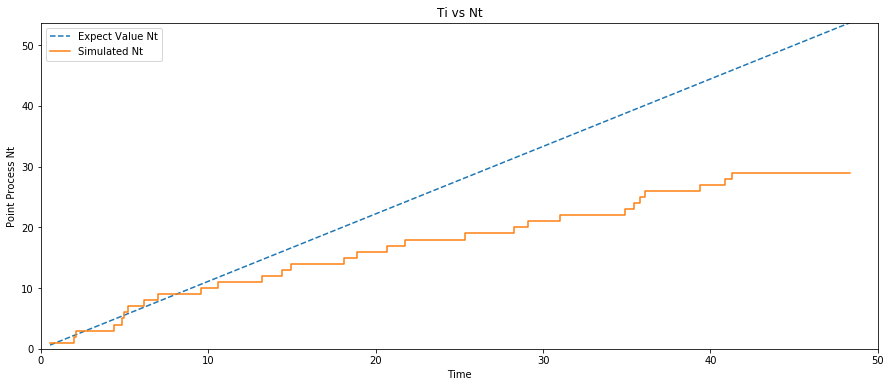

In [13]:
E_Nt=(mu1H * rho + a * delta)*T/(delta- mu1G)
E_Nt1=[]
i=0
while i<len(Ti):
    
    E_Nt2=(mu1H * rho + a * delta)*Ti[i]/(delta- mu1G)
    E_Nt1.append(E_Nt2)
    i=i+1
    if i==10000000:
        break
    

    
plt.figure(figsize=(15,6))
plt.plot(Ti,E_Nt1,linestyle='--',label='Expect Value Nt')
plt.step(Ti,Nt,where='post', label='Simulated Nt')
plt.title('Ti vs Nt')
plt.xlim(0,T)
plt.ylim(0,np.max(E_Nt1))
plt.xlabel('Time')
plt.ylabel('Point Process Nt')
plt.legend()
print(np.max(Nt),E_Nt)

$\quad$

Se realiza la simulación del tamaño de las reclamaciones que siguen distribución Erlang Tipo 3. Únicamente se tienen en cuenta los saltos internos para su cálculo.

In [14]:
#Comparación entre distribuciones del número de reclamaciones. 
x=[]
y=[]
y2=[]
gamma=1.0
i=0
for i in range(0,200):
    x1=np.random.gamma(1,scale=1/gamma)
    y1=np.random.gamma(2,scale=1/gamma)
    y_2=np.random.gamma(3,scale=1/gamma)
    x.append(x1)
    y.append(y1)
    y2.append(y_2)
    i=i+1
    if i==200000:
        break

199.62074965708865 381.11490302080875 616.60078261113


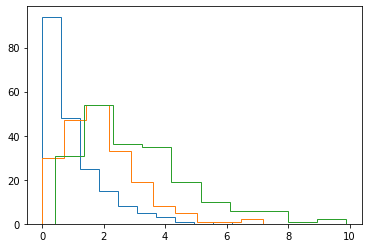

In [17]:
plt.hist(x,histtype='step')
plt.hist(y,histtype='step')
plt.hist(y2,histtype='step')
print(np.sum(x),np.sum(y),np.sum(y2))

$\quad$

In [51]:
z=[]
i=0
k=2
while i<len(Nt):
    y=np.random.gamma(k,scale=1/gamma)
    z.append(y)
    i=i+1
    if i==200000:
        break
mu1G=describe(sizeSJ).mean
mu1H=describe(sizeEJ).mean
mu1Z=describe(z).mean

$\quad$

Se comprueba que se cumpla la condición de ganancia neta para la prima $c$ dada en los parámetros iniciales

$\quad$

In [52]:
net=((mu1H* rho + a * delta)*mu1Z)/(delta-mu1G)
if c>net:
    print('Satisfy the Net Profit Condition')
else:
    print('Does not satisfy the Net Profit Condition')



Does not satisfy the Net Profit Condition


In [53]:
#Tamaño de la reclamación y número de reclamaciones
print(np.size(z),z)

58 [2.7805003380573865, 0.4958331006649705, 0.6607687220052698, 0.6824868007103674, 1.991231159042306, 2.0404659276517148, 5.7038300219717915, 1.0959412392862866, 2.9685093054544938, 0.733112678761427, 0.9615573239777631, 2.6898739916732652, 1.3826951526157139, 2.5738342194374493, 0.22393106030840618, 1.3324962292939417, 2.0527169493654447, 1.096817956829212, 1.5076566110000076, 3.6951172643021613, 2.6392406807235727, 3.1123326134131712, 2.626978942048222, 1.3687787169809005, 1.1627792900540612, 4.445754038426736, 1.2390251324029515, 1.2406489399935154, 2.1522773287200296, 5.233528885957958, 1.4313649254142353, 3.934258268219248, 1.4273429401521442, 5.0198508246642675, 0.8029048983149918, 1.2542272052491694, 1.7029407358168145, 9.143549932511537, 1.2817256917928435, 0.7742695879512207, 0.5365291135969816, 4.7625522203532284, 2.0746911406600845, 1.8143476951030446, 1.1913597791999964, 1.994297049680409, 5.6249197399275825, 2.206270013992864, 1.7182541883801816, 0.6255820146497092, 2.153

In [54]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        h=Nt[0]
        
    else:
        h=Nt[i]-Nt[i-1]
    Nt_final.append(h)    
    i=i+1
    if i ==10000000:
        break

In [55]:
#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

In [56]:
#Tamaño de los saltos internos
z_S = list(map(operator.mul, z, Nt_final))

In [57]:
X_t=[]
i=0
while i<len(Ti):
    xt=x_0+c*(Ti[i])-np.cumsum(z_S)[i]
    X_t.append(xt)
    i=i+1
    if i==2000000:
        break

$\quad$

Dada la prima $c$, se procede a calcular el superávit de la compañía para la ventana de tiempo $t$.



$\quad$

In [58]:
i=0
h=0
X_t_2=X_t
Ti_2=Ti
while i < len(z_S):
    if z_S[i]!=0:
        
        X_t_a=X_t_2[:i+h]
        X_t_a.append(z_S[i]+X_t[i])
        X_t_b=X_t_2[i+h:]
        X_t_2=X_t_a+X_t_b
        
        Ti_a=Ti_2[:i+h]
        Ti_a.append(Ti[i])
        Ti_b=Ti_2[i+h:]
        Ti_2=Ti_a+Ti_b
        h+=1
    i+=1

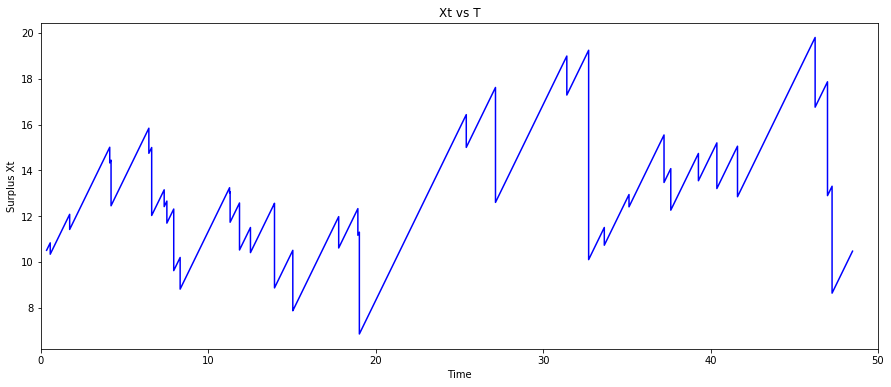

In [59]:
plt.figure(figsize=(15,6))
plt.plot(Ti_2,X_t_2,color='blue')
plt.title('Xt vs T')
plt.xlim(0,T)
#plt.ylim(-np.max(X_t_2),np.max(X_t_2)+10)
plt.xlabel('Time')
plt.ylabel('Surplus Xt')
plt.savefig("surplus_erlang.jpg", bbox_inches='tight')

$\quad$